In [1]:
import pandas as pd
import re
import time
import binascii
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
small_dataset = 'data/news_articles_small.csv'
df_small_dataset = pd.read_csv(small_dataset)

In [3]:
"""
    Pre-process data:
        1. convert all to lowercase
        2. remove punctuation
"""

#Convert to lowercase.
df_small_dataset['article'] = df_small_dataset['article'].str.lower()

#Remove punctuation
p = re.compile(r'[^\w\s]+')
df_small_dataset['article'] = [p.sub('', x) for x in df_small_dataset['article'].tolist()]

In [4]:
"""
    Split each document in a list of words

    small_dataset_split = [
        [documentID, document_text]
    ]
"""

small_dataset_split = []
for idx, row in df_small_dataset.iterrows():
    small_dataset_split.append([row[0], row[1].split()])

In [5]:
"""
    createShingles

    To create the shingles for the articles in the dataframe
    @:param small_dataset_split - The dataframe with the articles
"""

def createShingles(small_dataset_split):
#Add shingles with ngram 5
#Source: https://github.com/chrisjmccormick/MinHash/blob/master/runMinHashExample.py
    shingledDocs = {}
    docIds = []

    t0 = time.time()

    totalShingles = 0
    for docId, article in small_dataset_split:
        shingles = set()
        for i in range(0, len(article) - 4):
            shingle = article[i]+ " " + article[i + 1] + " " + article[i + 2] + " " + article[i + 3] + " " + article[i + 4]

            crc =  binascii.crc32(shingle.encode()) & 0xffffffff
            shingles.add(crc)

        shingledDocs[docId]= shingles
        docIds.append(docId)
        totalShingles = totalShingles + (len(article) - 4)

    t1 = time.time()
    print('Time spent: ', t1-t0)
    return shingledDocs, docIds, totalShingles

In [6]:
"""
    randomHash

    To create random hash functions
    @:param value
    @:param rand_value
"""
def randomHash(value, rand_value):
    return binascii.crc32(value.to_bytes(32, "little")) ^ rand_value

"""
    randomList

    To create random hash functions
    @:param value
    @:param seed
"""
def randomList(n, seed=10):
    random.seed(10)
    l = []
    for i in range(n):
        r = random.getrandbits(32)
        l.append(r)
    return l


In [7]:
shingledDocs, docIds, totalShingles = createShingles(small_dataset_split)

Time spent:  0.3925793170928955


In [37]:
print("Generating random hash functions...")
# Number of hash functions
M = 1000
random_values = randomList(M)

Generating random hash functions...


In [38]:
"""
    MinHashing from shingles
"""
signatures = []
t0 = time.time()
for doc in docIds:
    signature = []
    for hash_fun in range(M):
        min_value = 0
        random_value = random_values[hash_fun]
        for shingle in shingledDocs[doc]:
            hash_value = randomHash(shingle, random_value)
            if hash_value < min_value or min_value == 0:
                min_value = hash_value
        
        signature.append(min_value)
    signatures.append(signature)

t1= time.time()

print('Time spent: ', t1-t0)

Time spent:  244.52565169334412


## Method 1


In [39]:
#Confusion matrix, Accuracy, sensitivity and specificity
from sklearn.metrics import confusion_matrix

def calc_metrics(df):

    cm = confusion_matrix(df[['label_real']],df[['label_calc']])
    print('Confusion Matrix : \n', cm)

    total=sum(sum(cm))
    #####from confusion matrix calculate accuracy
    accuracy=(cm[0,0]+cm[1,1])/total
    specificity = cm[0,0]/(cm[0,0]+cm[0,1])
    sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
    precision = cm[1,1]/(cm[0,1]+cm[1,1])
    
    return accuracy, specificity, sensitivity, precision

In [40]:
def check_metrics(candidates, results, weights):
    sim = pd.DataFrame(list(candidates), columns=["doc1", "doc2"])
    sim['label'] = 1
    merged = real_sim.merge(sim, left_on=['doc1','doc2'], right_on=['doc1','doc2'], suffixes=['_real', '_calc'], how="left")
    merged = merged.fillna(0)
    metrics = calc_metrics(merged)
    mult = [a*b for a,b in zip(weights,metrics)]
    combined = float(sum(mult) / sum(weights))
    print(" Accuracy: ", metrics[0], "\n Specificity: ", metrics[1],
     "\n Sensitivity: ", metrics[2],"\n Precision: ", metrics[3], 
          "\n combined: ", combined)
    
    return metrics, combined

In [41]:
real_sim = pd.read_csv("real_sim.csv")
real_sim['label'] = np.where(real_sim['sim'] >= 0.8, 1, 0)
real_sim.head()

,Unnamed: 0,doc1,doc2,sim,label
0,0,0,1,0.058333,0
1,1,0,2,0.058333,0
2,2,0,3,0.067669,0
3,3,0,4,0.054852,0
4,4,0,5,0.072650,0


In [42]:
from numpy import long

"""
    LSH
"""
from itertools import combinations

class LSH:
    def __init__(self, b, r):
        self.counter = 0
        self.b = b
        self.r = r
        self.hash_tables= {}

        self.create_hash_tables()

    def create_hash_tables(self):
        # The hash function must be (s1, s2, p1, p2) sensitive
        # We need to have r hash functions
        # Per band we have a hash table

        # Add hash tables
        for i in range(self.b):
            self.hash_tables[i] = {}

    def hash(self, i, subvec):
        acc = ""
        for value in subvec:
            acc += str(int(float(value)))
        return acc

    def add_to_hash_table(self, i, subvec):
        if subvec not in self.hash_tables[i]:
            self.hash_tables[i][subvec] = []
            self.hash_tables[i][subvec].append(self.counter)
        else:
            self.hash_tables[i][subvec].append(self.counter)

    def make_subvecs(self, signature):
        l = len(signature)
        assert l % self.b == 0
        r = self.r
        # break signature into subvectors
        subvecs = []
        for i in range(0, l, r):
            subvecs.append(signature[i:i+r])
        return np.stack(subvecs)

    def add_hash(self, signature):
        subvecs = self.make_subvecs(signature).astype(str)
        for i, subvec in enumerate(subvecs):
            #Hash every subvector using another hash function
            #and add it to a different hash table that corresponds
            #to that hash function
            hashed_subvec = self.hash(i+1, subvec)
            self.add_to_hash_table(i, hashed_subvec)
        self.counter += 1

    def check_candidates(self):
        candidates = []
        for i in self.hash_tables:
            
            keys = self.hash_tables[i].keys()
            for bucket in keys:
                hits = self.hash_tables[i][bucket]
                if len(hits) > 1:
                    candidates.extend(combinations(hits, 2))
        return set(candidates)

C:\Users\Katerina\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


In [43]:
def parameters(s, r, p):
    b = round(np.log(1-p) / np.log(1-s**r))
    M = r * b
    return (b,r), (s,p)

In [44]:
def get_ops(similarities, rows, probabilities):
    ops = []
    for s in similarities:
        for r in rows:
            for p in probabilities:
                params, v = parameters(s, r, p)
                l = params[0] * params[1]
                if l <= len(signatures[0]) and l > 80:
                    ops.append((params, v))
    return ops

In [45]:
rows = np.linspace(2,10,9)
probabilities = [0.7, 0.8, 0.9, 0.95, 0.99]
similarities = np.linspace(0.4,0.9,6)
ops = get_ops(similarities, rows, probabilities)
print(len(ops))

78


In [51]:
best_comb = 0
res = []
# accuracy, spec, sens, precision
weights = [0,0,2,2]
t0 = time.time()
for op in ops:
    b = int(op[0][0])
    r = int(op[0][1])
    lsh = LSH(b,r)
    l = b * r
    for signature in signatures:
        lsh.add_hash(signature[:l])

    candidate_pairs = lsh.check_candidates()
    print(f"Candidate pairs for n={l} b={b} and r={r} ", op[1])
    print(f"Number of candidate pairs are {len(candidate_pairs)}")
    metrics, comb = check_metrics(candidate_pairs, real_sim, weights)
    if comb > best_comb:
        best_comb = comb
    res.append([comb, b, r, l, op[1], metrics])
    print("="*100)
t1 = time.time()
print("time spent: ", t1-t0)
print("best_res: ", best_comb)

Candidate pairs for n=105 b=35 and r=3  (0.4, 0.9)
Number of candidate pairs are 88
Confusion Matrix : 
 [[499411     64]
 [     1     24]]
 Accuracy:  0.9998698698698699 
 Specificity:  0.9998718654587316 
 Sensitivity:  0.96 
 Precision:  0.2727272727272727 
 combined:  0.6163636363636363
Candidate pairs for n=135 b=45 and r=3  (0.4, 0.95)
Number of candidate pairs are 95
Confusion Matrix : 
 [[499404     71]
 [     1     24]]
 Accuracy:  0.9998558558558559 
 Specificity:  0.9998578507432805 
 Sensitivity:  0.96 
 Precision:  0.25263157894736843 
 combined:  0.6063157894736841
Candidate pairs for n=210 b=70 and r=3  (0.4, 0.99)
Number of candidate pairs are 108
Confusion Matrix : 
 [[499392     83]
 [     0     25]]
 Accuracy:  0.9998338338338338 
 Specificity:  0.9998338255167927 
 Sensitivity:  1.0 
 Precision:  0.23148148148148148 
 combined:  0.6157407407407407
Candidate pairs for n=184 b=46 and r=4  (0.4, 0.7)
Number of candidate pairs are 58
Confusion Matrix : 
 [[499441     34

Candidate pairs for n=612 b=102 and r=6  (0.5, 0.8)
Number of candidate pairs are 43
Confusion Matrix : 
 [[499456     19]
 [     1     24]]
 Accuracy:  0.99995995995996 
 Specificity:  0.9999619600580609 
 Sensitivity:  0.96 
 Precision:  0.5581395348837209 
 combined:  0.7590697674418605
Candidate pairs for n=876 b=146 and r=6  (0.5, 0.9)
Number of candidate pairs are 47
Confusion Matrix : 
 [[499452     23]
 [     1     24]]
 Accuracy:  0.999951951951952 
 Specificity:  0.9999539516492317 
 Sensitivity:  0.96 
 Precision:  0.5106382978723404 
 combined:  0.7353191489361701
Candidate pairs for n=88 b=22 and r=4  (0.6000000000000001, 0.95)
Number of candidate pairs are 45
Confusion Matrix : 
 [[499451     24]
 [     4     21]]
 Accuracy:  0.9999439439439439 
 Specificity:  0.9999519495470244 
 Sensitivity:  0.84 
 Precision:  0.4666666666666667 
 combined:  0.6533333333333333
Candidate pairs for n=132 b=33 and r=4  (0.6000000000000001, 0.99)
Number of candidate pairs are 53
Confusion 

Candidate pairs for n=144 b=24 and r=6  (0.7000000000000001, 0.95)
Number of candidate pairs are 27
Confusion Matrix : 
 [[499465     10]
 [     8     17]]
 Accuracy:  0.9999639639639639 
 Specificity:  0.9999799789779268 
 Sensitivity:  0.68 
 Precision:  0.6296296296296297 
 combined:  0.6548148148148148
Candidate pairs for n=222 b=37 and r=6  (0.7000000000000001, 0.99)
Number of candidate pairs are 30
Confusion Matrix : 
 [[499464     11]
 [     6     19]]
 Accuracy:  0.999965965965966 
 Specificity:  0.9999779768757195 
 Sensitivity:  0.76 
 Precision:  0.6333333333333333 
 combined:  0.6966666666666667
Candidate pairs for n=98 b=14 and r=7  (0.7000000000000001, 0.7)
Number of candidate pairs are 12
Confusion Matrix : 
 [[499471      4]
 [    17      8]]
 Accuracy:  0.9999579579579579 
 Specificity:  0.9999919915911707 
 Sensitivity:  0.32 
 Precision:  0.6666666666666666 
 combined:  0.4933333333333333
Candidate pairs for n=133 b=19 and r=7  (0.7000000000000001, 0.8)
Number of can

Candidate pairs for n=140 b=20 and r=7  (0.8, 0.99)
Number of candidate pairs are 14
Confusion Matrix : 
 [[499470      5]
 [    16      9]]
 Accuracy:  0.9999579579579579 
 Specificity:  0.9999899894889634 
 Sensitivity:  0.36 
 Precision:  0.6428571428571429 
 combined:  0.5014285714285714
Candidate pairs for n=104 b=13 and r=8  (0.8, 0.9)
Number of candidate pairs are 10
Confusion Matrix : 
 [[499473      2]
 [    17      8]]
 Accuracy:  0.999961961961962 
 Specificity:  0.9999959957955854 
 Sensitivity:  0.32 
 Precision:  0.8 
 combined:  0.56
Candidate pairs for n=128 b=16 and r=8  (0.8, 0.95)
Number of candidate pairs are 10
Confusion Matrix : 
 [[499473      2]
 [    17      8]]
 Accuracy:  0.999961961961962 
 Specificity:  0.9999959957955854 
 Sensitivity:  0.32 
 Precision:  0.8 
 combined:  0.56
Candidate pairs for n=200 b=25 and r=8  (0.8, 0.99)
Number of candidate pairs are 13
Confusion Matrix : 
 [[499472      3]
 [    15     10]]
 Accuracy:  0.9999639639639639 
 Specific

In [23]:
results = pd.DataFrame.from_records(res, columns=['combined', 'b', 'r', 'M', 'vals', 'metrics'])
results['similarity'], results['probability']=results.vals.str
results['acc'], results['spec'], results['sens'], results['prec']=results.metrics.str
results = results.drop(['vals', 'metrics'], axis=1)

In [24]:
results.shape

(62, 10)

In [25]:
results.head()

,combined,b,r,M,similarity,probability,acc,spec,sens,prec
0,0.616364,35,3,105,0.4,0.90,0.999870,0.999872,0.96,0.272727
1,0.606316,45,3,135,0.4,0.95,0.999856,0.999858,0.96,0.252632
2,0.615741,70,3,210,0.4,0.99,0.999834,0.999834,1.00,0.231481
3,0.686897,46,4,184,0.4,0.70,0.999930,0.999932,0.96,0.413793
4,0.695312,62,4,248,0.4,0.80,0.999922,0.999922,1.00,0.390625


In [26]:
# results.to_csv("results.csv")

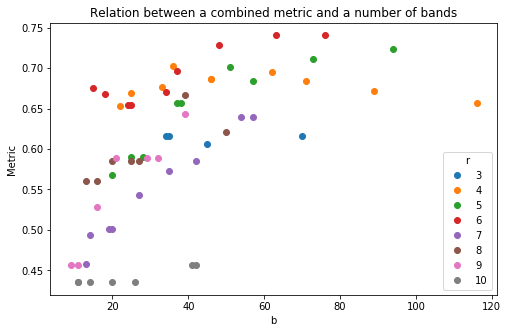

In [59]:
plt.figure(figsize=(8,5))
groups = results.groupby("r")
for name, group in groups:
    plt.plot(group["b"], group["combined"], marker="o", linestyle="", label=name)
plt.legend(title="r")

plt.xlabel('b')
plt.ylabel('Metric')
plt.title("Relation between a combined metric and a number of bands")
plt.show()

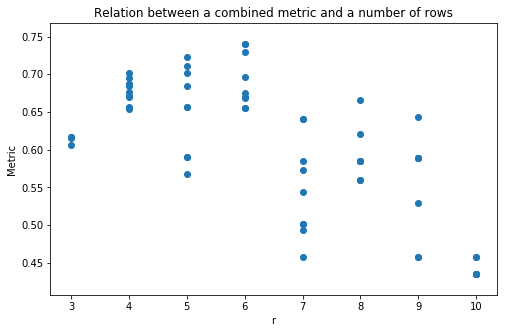

In [60]:
plt.figure(figsize=(8,5))
plt.scatter(results["r"],results["combined"])
# plt.legend()
plt.xlabel('r')
plt.ylabel('Metric')
plt.title("Relation between a combined metric and a number of rows")
plt.show()

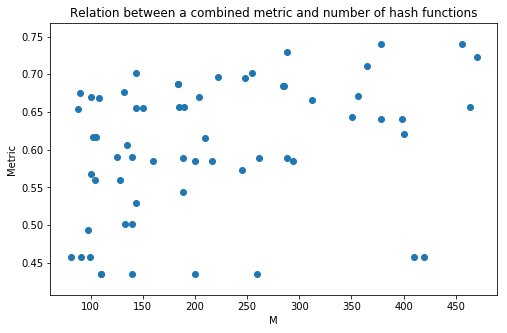

In [61]:
plt.figure(figsize=(8,5))
plt.scatter(results["M"],results["combined"])
plt.xlabel('M')
plt.ylabel('Metric')
plt.title("Relation between a combined metric and number of hash functions")
plt.show()

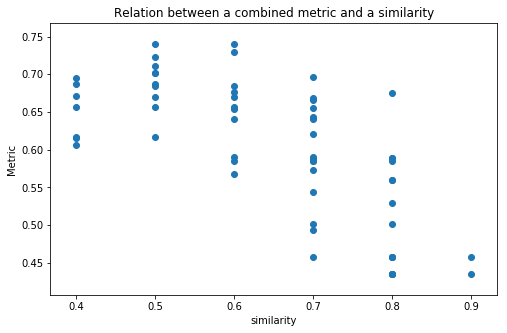

In [62]:
plt.figure(figsize=(8,5))
plt.scatter(results["similarity"],results["combined"])
plt.xlabel('similarity')
plt.ylabel('Metric')
plt.title("Relation between a combined metric and a similarity")
plt.show()

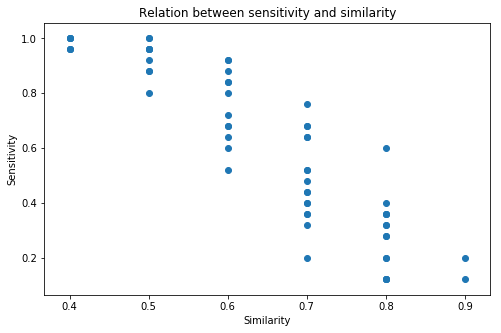

In [63]:
plt.figure(figsize=(8,5))
plt.scatter(results["similarity"],results["sens"])
plt.xlabel('Similarity')
plt.ylabel('Sensitivity')
plt.title("Relation between sensitivity and similarity")
plt.show()

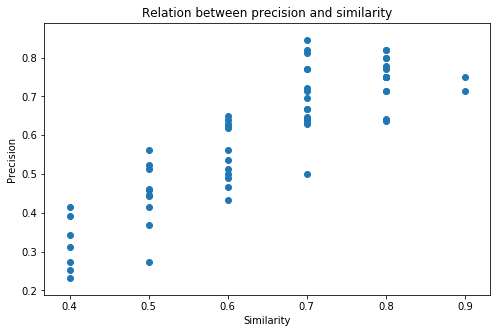

In [64]:
plt.figure(figsize=(8,5))
plt.scatter(results["similarity"],results["prec"])
plt.xlabel('Similarity')
plt.ylabel('Precision')
plt.title("Relation between precision and similarity")
plt.show()

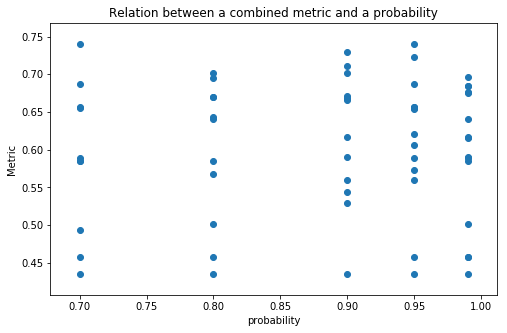

In [65]:
plt.figure(figsize=(8,5))
plt.scatter(results["probability"],results["combined"])
plt.xlabel('probability')
plt.ylabel('Metric')
plt.title("Relation between a combined metric and a probability")
plt.show()

In [109]:
results[results.combined == results.combined.max()]

,combined,b,r,M,similarity,probability,acc,spec,sens,prec
21,0.75907,102,6,612,0.5,0.80,0.99996,0.999962,0.96,0.55814
33,0.75907,96,6,576,0.6,0.99,0.99996,0.999962,0.96,0.55814



## Parameters

In [23]:
def prob_fun(r,b,p):
    return 1-(1-p**r)**b

In [42]:
rows = np.linspace(2,7,6)
probabilities = [0.95]
similarities = [0.8]
# similarities = np.linspace(0.5,0.9,5)
ops = get_ops(similarities, rows, probabilities)
print(len(ops))

6


In [43]:
for op in ops:
    print(op)
pts = np.linspace(0,1,100)


((3, 2.0), (0.8, 0.95))
((4, 3.0), (0.8, 0.95))
((6, 4.0), (0.8, 0.95))
((8, 5.0), (0.8, 0.95))
((10, 6.0), (0.8, 0.95))
((13, 7.0), (0.8, 0.95))


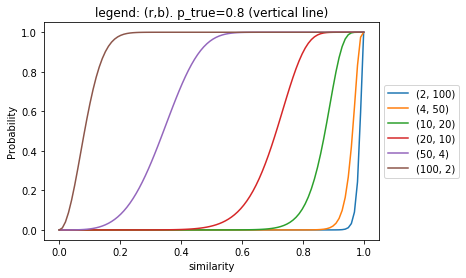

In [29]:

n = 200
ops = [(2,100),(4,50),(10,20),(20,10),(50,4),(100,2)]

for op in ops:
#     plt.subfigure(subfigsize=(10,5))
#     plt.plot(pts, prob_fun(op[0][1], op[0][0], pts ), label=op)    
    plt.plot(pts, prob_fun(op[1], op[0], pts ), label=op)    

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('similarity')
plt.ylabel('Probability')
plt.title("legend: (r,b). p_true=0.8 (vertical line)")
plt.show()

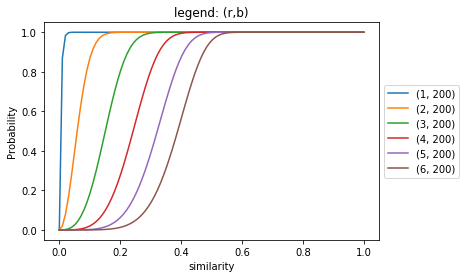

In [34]:

n = 200
ops = [(1,200),(2,200),(3, 200),(4,200),(5, 200),(6, 200)]

for op in ops:
#     plt.subfigure(subfigsize=(10,5))
#     plt.plot(pts, prob_fun(op[0][1], op[0][0], pts ), label=op)    
    plt.plot(pts, prob_fun(op[0], op[1], pts ), label=op)    

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('similarity')
plt.ylabel('Probability')
plt.title("legend: (r,b)")
plt.show()

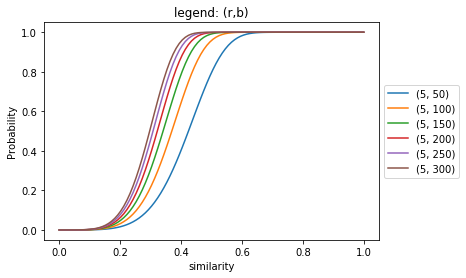

In [54]:

n = 200
ops = [(5,50),(5,100),(5, 150),(5,200),(5, 250),(5, 300)]

for op in ops:
#     plt.subfigure(subfigsize=(10,5))
#     plt.plot(pts, prob_fun(op[0][1], op[0][0], pts ), label=op)    
    plt.plot(pts, prob_fun(op[0], op[1], pts ), label=op)    

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('similarity')
plt.ylabel('Probability')
plt.title("legend: (r,b)")
plt.show()

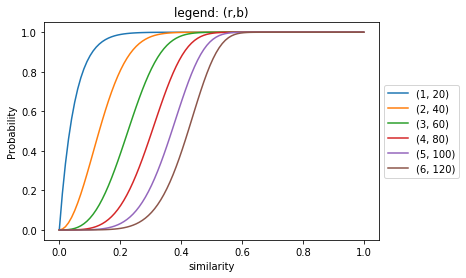

In [37]:

n = 200
ops = [(1,20),(2,40),(3, 60),(4, 80),(5,100),(6, 120)]

for op in ops:
#     plt.subfigure(subfigsize=(10,5))
#     plt.plot(pts, prob_fun(op[0][1], op[0][0], pts ), label=op)    
    plt.plot(pts, prob_fun(op[0], op[1], pts ), label=op)    

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('similarity')
plt.ylabel('Probability')
plt.title("legend: (r,b)")
plt.show()

6


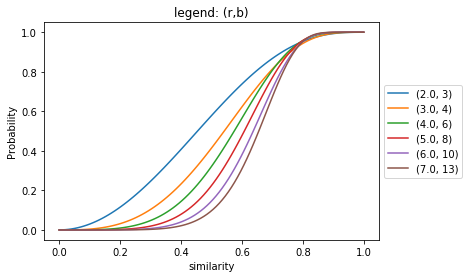

In [53]:
rows = np.linspace(2,7,6)
probabilities = [0.95]
similarities = [0.8]
# similarities = np.linspace(0.5,0.9,5)
ops = get_ops(similarities, rows, probabilities)
print(len(ops))

for op in ops:
#     plt.subfigure(subfigsize=(10,5))
    plt.plot(pts, prob_fun(op[0][1], op[0][0], pts ), label=(op[0][1], op[0][0]))    
#     plt.plot(pts, prob_fun(op[0], op[1], pts ), label=op)    

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('similarity')
plt.ylabel('Probability')
plt.title("legend: (r,b)")
plt.show()

5


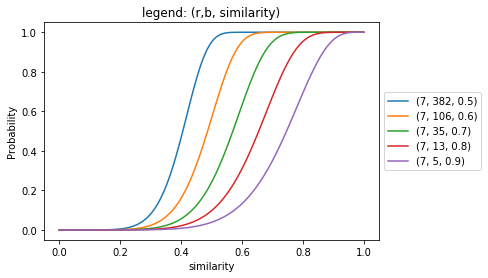

In [57]:
# rows = np.linspace(2,7,6)
rows = [7]
probabilities = [0.95]
# similarities = [0.8]
similarities = np.linspace(0.5,0.9,5)
ops = get_ops(similarities, rows, probabilities)
print(len(ops))

for op in ops:
#     plt.subfigure(subfigsize=(10,5))
    plt.plot(pts, prob_fun(op[0][1], op[0][0], pts ), label=(op[0][1], op[0][0], op[1][0]))    
#     plt.plot(pts, prob_fun(op[0], op[1], pts ), label=op)    

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('similarity')
plt.ylabel('Probability')
plt.title("legend: (r,b, similarity)")
plt.show()

In [49]:
ops

[((94, 5), (0.5, 0.95)),
 ((37, 5), (0.6, 0.95)),
 ((16, 5), (0.7, 0.95)),
 ((8, 5), (0.8, 0.95)),
 ((3, 5), (0.9, 0.95))]